# Verification experiment - NARMAX

In [ ]:
using Revise
using ProgressMeter
using LinearAlgebra
using JLD
using MAT
using Plots
pyplot();

include("algorithms/VMP-estimator-NARMAX.jl");
include("algorithms/RLS-estimator-NARMAX.jl");
include("experiments/util.jl");

## Data

Data is generated from a NARMAX system in a corresponding MATLAB script.

In [2]:
# Simulation noise
stde = 0.02;

# Polynomial degree
degree = 3;

# Model orders
M1 = 1
M2 = 1
M3 = 1
M = 1 + M1 + M2 + M3

# Maximum delay
maxM = maximum([M1, M2, M3])

# Polynomial
options = Dict("na" => M1,
               "nb" => M2,
               "ne" => M3,
               "nd" => degree,
               "dc" => false,
               "crossTerms" => true,
               "noiseCrossTerms" => false)

# Model basis function
PΦ = gen_combs(options)
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

# Number of coefficients after basis expansion
N = size(PΦ,2);

In [3]:
# Load from .mat file
mat_data = matread("datasets/data/NARMAXsignal_stde"*string(stde)*"_pol3_order4_N"*string(N)*"_r1.mat")

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:256) .+ transient

# Length of testing signal
ix_tst = collect(1:1000) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# System parameters
θ_true = mat_data["system"]["theta"][:]
τ_true = inv(mat_data["options"]["stde"]^2);

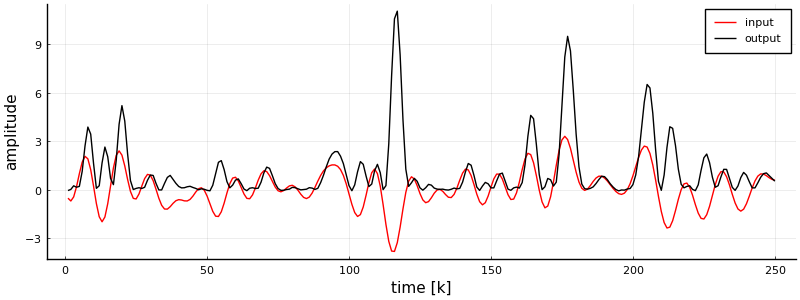

In [4]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_trn[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, output_trn[zoom_t], color="black", label="output")

Below we'll perform a 1-step ahead prediction error and a simulation error experiment using the true system parameters. Those represent the best performance achievable for a NARMAX model (a.k.a. oracle performance).

### 1-step ahead prediction error

In [5]:
predictions_SYS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Point prediction
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_SYS[k] = θ_true'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_SYS[k]

end

RMS_prd_SYS = sqrt(mean((predictions_SYS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.01945666065358758

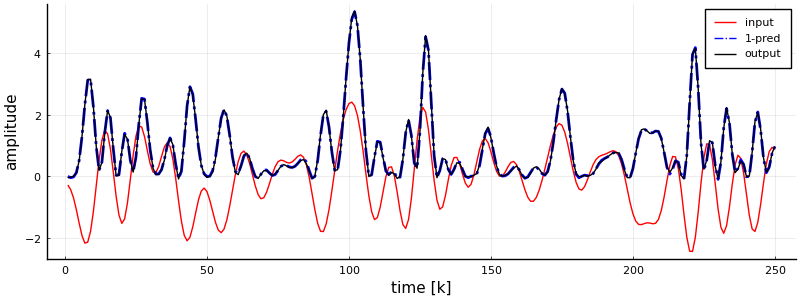

In [6]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_tst[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, predictions_SYS[zoom_t], color="blue", linewidth=2, linestyle=:dashdot,label="1-pred")
plot!(zoom_t, output_tst[zoom_t], color="black", label="output")

### Simulation error

In [7]:
simulations_SYS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_SYS[k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_SYS[k] = θ_true[:]'*ϕx

end

RMS_sim_SYS = sqrt(mean((simulations_SYS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.01957966363585063

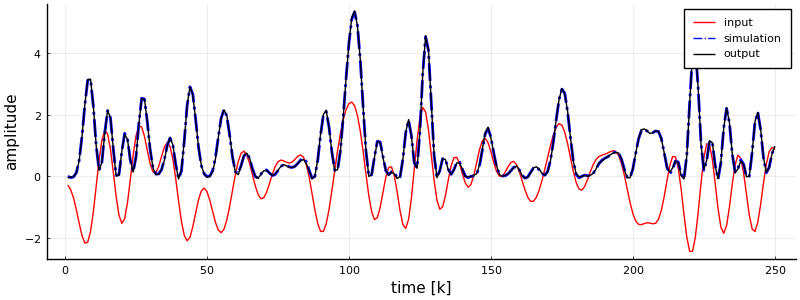

In [8]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_tst[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, simulations_SYS[zoom_t], color="blue", linewidth=2, linestyle=:dashdot, label="simulation")
plot!(zoom_t, output_tst[zoom_t], color="black", label="output")

## Estimator: Free Energy Minimisation

In [9]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafePrecision
using NARMAX

In [10]:
graph = FactorGraph()

# Observed variables
@RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
@RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
@RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N, N)))

# Likelihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

### Estimate parameters

In [11]:
# Initialize priors
θ_0 = (zeros(N,), Matrix{Float64}(I,N,N))
τ_0 = (20, 0.01)
mτ = τ_0[1]/τ_0[2]

2000.0

In [12]:
# Zero-padding of signals
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

T_trn += maxM
T_tst += maxM

"Inference execution"

# Number of VMP iterations
num_iters = 10;

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_0[1], w=θ_0[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_0[1], b=τ_0[2]))

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
params_τ = (zeros(T_trn,1), zeros(T_trn,1))

# Initialize recursive parameters
θ_k = θ_0
τ_k = τ_0

# Preallocate prediction arrays
predictions_FEM = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions_FEM[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :u_kmin1 => u_kmin1,
                :y_kmin1 => y_kmin1,
                :e_kmin1 => e_kmin1,
                :m_θ => θ_k[1],
                :w_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


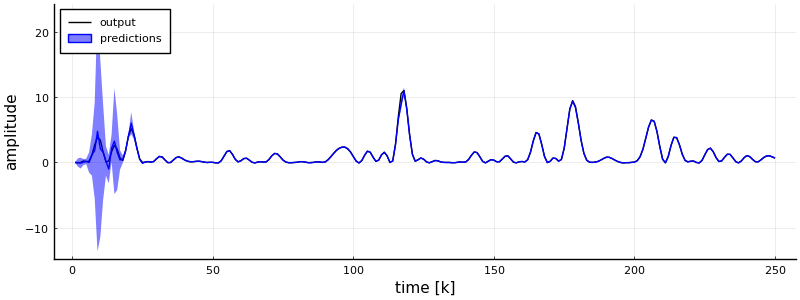

In [13]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, output_trn[zoom_t], color="black", label="output", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="predictions", legend=:topleft)

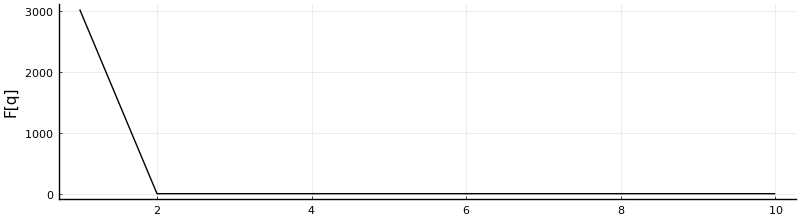

In [14]:
plot(mean(Fq, dims=1)', color="black", ylabel="F[q]", label="", size=(800,220))

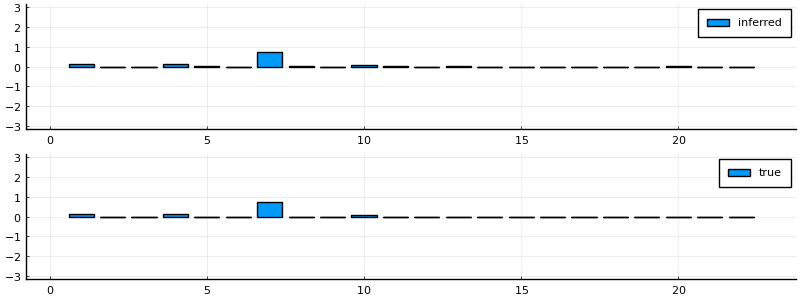

In [15]:
p55a = bar(θ_k[1], label="inferred", ylims=[-3.,3.])
p55b = bar(θ_true, label="true", ylims=[-3.,3.])
p55 = plot(p55a, p55b, layout=(2,1), size=(800,300))

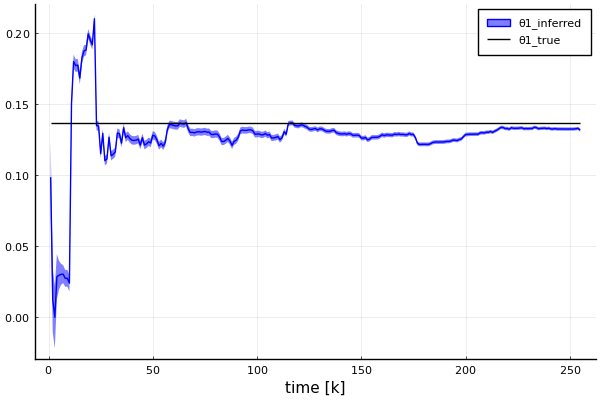

In [16]:
sdθ1 = sqrt.(inv.(params_θ[2][maxM+1:end,1,1]))
plot(params_θ[1][maxM+1:end,1], ribbon=[sdθ1 sdθ1], color="blue", xlabel="time [k]", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn-maxM-1,), color="black", label="θ1_true")

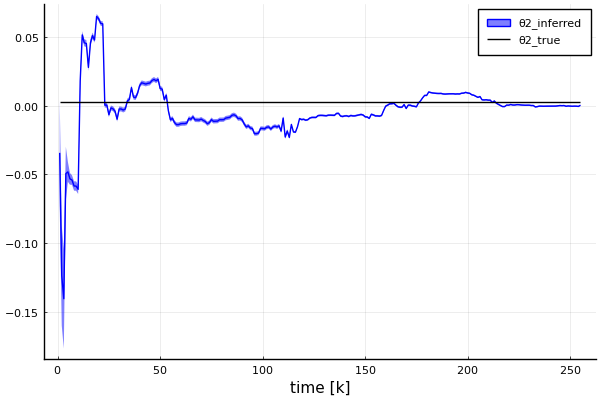

In [17]:
sdθ2 = sqrt.(inv.(params_θ[2][maxM+1:end,2,2]))
plot(params_θ[1][maxM+1:end,2], ribbon=[sdθ2 sdθ2], color="blue", xlabel="time [k]", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn-maxM-1,), color="black", label="θ2_true")

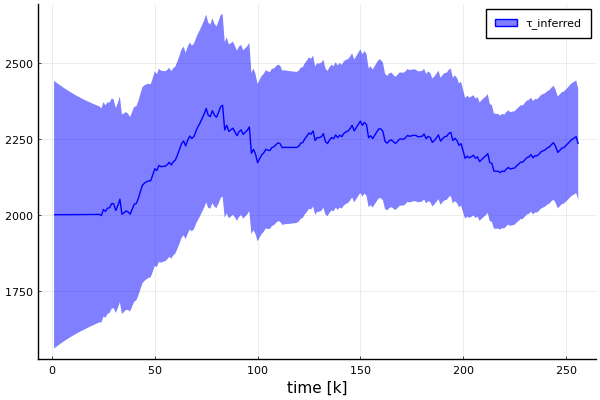

In [18]:
mτ = params_τ[1] ./ params_τ[2]
sτ = sqrt.(params_τ[1] ./ params_τ[2].^2)

plot(mτ, ribbon=[sτ sτ], color="blue", xlabel="time [k]", label="τ_inferred")
# plot!(τ_true*ones(T_trn,), color="black", label="τ_true")

### 1-step ahead prediction error

In [19]:
predictions_FEM = (zeros(T_tst,), zeros(T_tst,))
errors = zeros(T_tst,)

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])

    # Update error
    errors[k] = output_tst[k] - predictions_FEM[1][k]

end

# Compute root mean square error
RMS_prd_FEM = sqrt(mean((predictions_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.020224842418400172

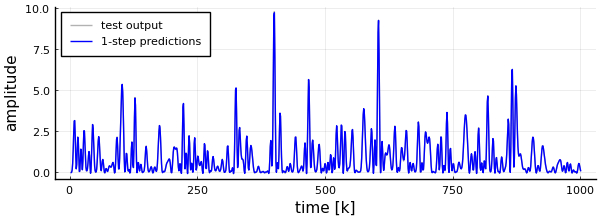

In [20]:
zoom_t = maxM+1:T_tst
p150 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, predictions_FEM[1][zoom_t], color="blue", label="1-step predictions")
# plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="1-step predictions")

In [21]:
savefig(p150, "experiments/figures/NARMAX-1steppredictions_deg"*string(degree)*"_order"*string(M)*"_FEM.png")

### Simulation error

In [22]:
simulations_FEM = (zeros(T_tst,), zeros(T_tst,))

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_FEM[1][k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

end

# Compute root mean squared error
RMS_sim_FEM = sqrt(mean((simulations_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.02052610337719122

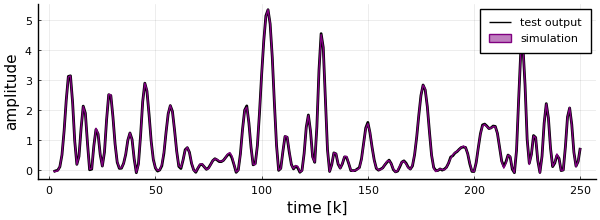

In [23]:
zoom_t = maxM+1:250
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=2, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, simulations_FEM[1][zoom_t], ribbon=[sqrt.(simulations_FEM[2][zoom_t]), sqrt.(simulations_FEM[2][zoom_t])], color="purple", label="simulation")

In [24]:
savefig(p210, "experiments/figures/NARMAX-simulation_deg"*string(degree)*"_order"*string(M)*"_FEM.png")

## Estimator: Recursive Least-Squares

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [25]:
# Forgetting factor
λ = 1.00

# Initialize
P = λ.*Matrix{Float64}(I,N,N)
w_k = zeros(N,)

# Preallocate prediction array
predictions_RLS = zeros(T_trn,)
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update data vector
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]
    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])

    # Update weights
    α = output_trn[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    errors[k] = output_trn[k] - predictions_RLS[k]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


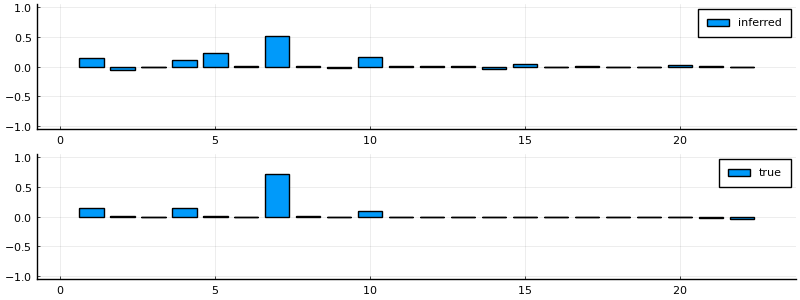

In [26]:
p55a = bar(w_k, label="inferred", ylims=[-1., 1.])
p55b = bar(θ_true, label="true", ylims=[-1., 1.])
p55 = plot(p55a, p55b, layout=(2,1), size=(800,300))

### 1-step ahead prediction error

In [27]:
predictions_RLS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Point prediction
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_RLS[k] = w_k'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_RLS[k]

end

RMS_prd_RLS = sqrt(mean((predictions_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.02221581941475088

### Simulation error

In [28]:
simulations_RLS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_RLS[k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_RLS[k] = w_k'*ϕx

end

RMS_sim_RLS = sqrt(mean((simulations_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.023031683115305398

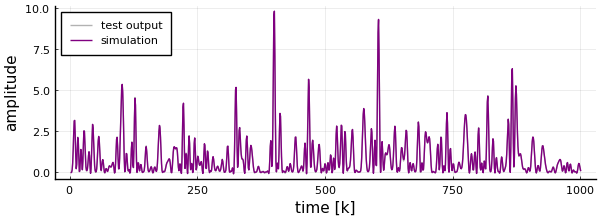

In [29]:
zoom_t = maxM+1:T_tst
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, simulations_RLS[zoom_t], color="purple", label="simulation")

## Estimator: Iterative Least-Squares

In [30]:
results_ILS = matread("experiments/results/results-NARMAX_ILS_stde"*string(stde)*"_pol3_M"*string(M)*"_N"*string(N)*"_degree3_r1.mat")
RMS_prd_ILS = results_ILS["RMS_prd"][2]
RMS_sim_ILS = results_ILS["RMS_sim"][2]

0.020662889357031346

In [31]:
save("results/sweep-noise-prior-a"*string(τ_0[1])*"_b"*string(τ_0[2])*"_stde"*string(stde)*"_pol3_order4_N"*string(N)*"_r1.jld", "tau_0", τ_0, "params_tau", params_τ, "RMS_sim_FEM", RMS_sim_FEM, "RMS_prd_FEM", RMS_prd_FEM, "RMS_sim_RLS", RMS_sim_RLS, "RMS_prd_RLS", RMS_prd_RLS, "RMS_sim_ILS", RMS_sim_ILS, "RMS_prd_ILS", RMS_prd_ILS)

## Comparisons

In [32]:
transient_sim = 10
sqerror_sim_FEM = (simulations_FEM[1][transient_sim:T_tst] - output_tst[transient_sim:T_tst]).^2
sqerror_sim_RLS = (simulations_RLS[transient_sim:T_tst] - output_tst[transient_sim:T_tst]).^2

RMS_sim_FEM = sqrt(mean(sqerror_sim_FEM))
RMS_sim_RLS = sqrt(mean(sqerror_sim_RLS))

println("RMS sim FEM = "*string(RMS_sim_FEM))
println("RMS sim RLS = "*string(RMS_sim_RLS))
println("RMS sim ILS = "*string(RMS_sim_ILS))
println("RMS sim SYS = "*string(RMS_sim_SYS))

RMS sim FEM = 0.02057180120566411
RMS sim RLS = 0.023082539999026427
RMS sim ILS = 0.020662889357031346
RMS sim SYS = 0.01957966363585063


In [33]:
prop_beaten = mean(sqerror_sim_FEM .< sqerror_sim_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 57.0%


In [34]:
transient_prd = 100
sqerror_prd_FEM = (predictions_FEM[1][transient_prd:T_tst] - output_tst[transient_prd:T_tst]).^2
sqerror_prd_RLS = (predictions_RLS[transient_prd:T_tst] - output_tst[transient_prd:T_tst]).^2

RMS_prd_FEM = sqrt(mean(sqerror_prd_FEM))
RMS_prd_RLS = sqrt(mean(sqerror_prd_RLS))

println("RMS prd FEM = "*string(RMS_prd_FEM))
println("RMS prd RLS = "*string(RMS_prd_RLS))
println("RMS prd ILS = "*string(RMS_prd_ILS))
println("RMS prd SYS = "*string(RMS_prd_SYS))

RMS prd FEM = 0.020283680275426364
RMS prd RLS = 0.022287186270791483
RMS prd ILS = 0.020347136112154992
RMS prd SYS = 0.01945666065358758


In [35]:
prop_beaten = mean(sqerror_prd_FEM .< sqerror_prd_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 57.0%
